In [93]:
import pandas as pd
import numpy as np
import sklearn.decomposition
from scipy import stats
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import emcee
import tissue_enrichment_analysis as tea
import matplotlib.patheffects as path_effects

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
# sns.set_style('darkgrid', rc=rc)
sns.set_style("dark")

import genpy

ft = 35 #title fontsize

# Mutants:

I have been given 4 single mutants and 2 double mutants. This is a blind study, so I don't know the identities of the mutants. 

Single mutants:

b, c, d, e

Double mutants:
$$
a = b^-d^-
$$

$$
f = b^-c^-
$$

In [94]:
# Specify the genotypes
single_mutants = ['b', 'c', 'd', 'e']
double_mutants = {'a' : 'bd', 'f':'bc'}

In [95]:
# This file tells me the genotype - project mapping. 
genmap = pd.read_csv('../input/library_genotype_mapping.txt', comment='#')
genmap.genotype = genmap.genotype.apply(str)
genmap.genotype = genmap.genotype.apply(str.lower) # make sure everything is always in lowercase

In [96]:
# Make all possible combinations of WT, X
combs = []
for gene in genmap.genotype.unique():
    if gene != 'wt':
        combs += [['WT', gene]]

In [97]:
# get all pandas tpm dataframes for each project
# tpm files are in kallisto_loc
kallisto_loc = '../input/kallisto_all/'

tpm = {}  # initialize an empty hash

# get tpm for each project
for prjct in genmap.project_name.unique():
    if 'JKY' in prjct or 'N2Y' in prjct:
        continue
    tpm[prjct] = pd.read_csv(kallisto_loc + prjct +'/kallisto/abundance.tsv', sep='\t')
    tpm[prjct].sort_values('target_id', inplace=True)

In [98]:
# load all the beta values for each genotype:
sleuth_loc = '../sleuth/'

beta = {}  # empty hash

# get betas for each genotype comparison:
for comb in combs:
    c = comb[0] + '_' + comb[1]
    beta[comb[1]] = pd.read_csv(sleuth_loc + c + '/betas.csv')
    
    # beta dataframes from sleuth MUST BE SORTED By ID!!!!
    # if you don't do this, nothing works!
    beta[comb[1]].sort_values('target_id', inplace=True)

# PCA Analysis of TPM Data

PCA analysis of TPM data should hopefully reveal some structure and clustering in this dataset. 

First, I want to know how many PCs explain >90% of the data, then build a PCA object with that
many dimensions which I will use for agglomerative clustering. 

In [99]:
# PCA
#exclude g
pca_matrix = genpy.make_matrix(tpm, genmap, 'project_name', 'tpm')
sklearn_pca, n = genpy.pca(pca_matrix)

The first 4 principal components explain >=90% of the data


In [100]:
# keep only the first principal components that explain 90% of the data
if n < 3:
    n = 3

df_nD = genpy.tidy_pca(pca_matrix, n)

# add a sample and genotype column
df_nD['samples'] = genmap.project_name.unique()
l = lambda x: genmap[genmap.project_name == x].genotype.values[0]
df_nD['genotypes'] = df_nD.samples.apply(l)
df_nD.head()

,PCA1,PCA2,PCA3,PCA4,samples,genotypes
0,-7597.070087,-2748.583552,-3246.871740,1290.455581,Project_17434_indexN704-N517,wt
1,11507.253519,-2051.481912,-1497.092629,-3054.503202,Project_17441_indexN704-N508,a
2,-3499.905323,5120.560035,-2885.212424,3672.694861,Project_17448_indexN705-N507,d
3,-7673.426882,-2525.724491,-1947.520648,5304.474756,Project_17435_indexN704-N502,wt
4,10090.924838,-3448.230513,-2854.242845,-456.802389,Project_17442_indexN705-N517,a


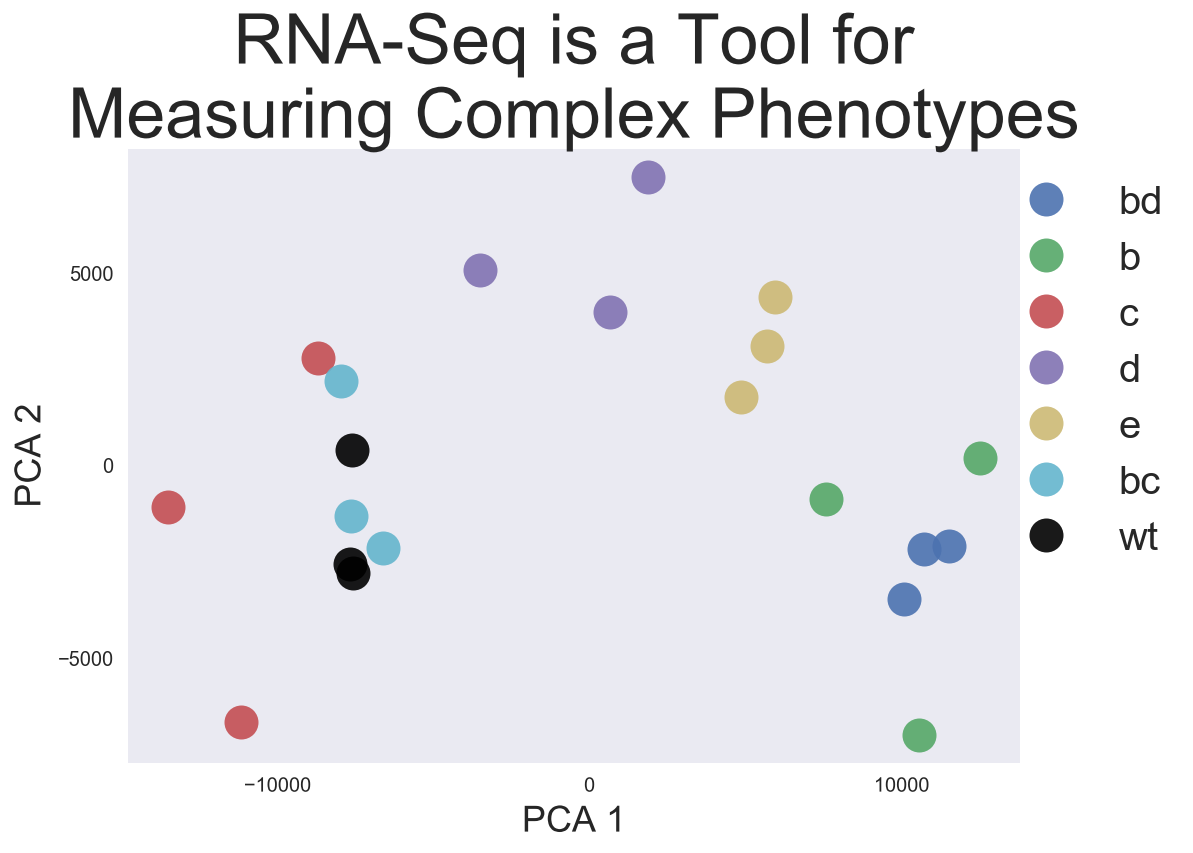

In [101]:
def plot_2d_pca(df_pca, group_col, special_key, double_mutant_hash= {},save=''):
    """
    Very basic wrapper around plt.plot to plot pca results after using tidy_pca.
    
    df_pca - df output by tidy_pca
    group_col - column in df_pca to group by
    special_key - if there's a particular group to color in black, use special_key
                  to identify it
    
    returns:
    a matplotlib object
    """
    # plot first 2d components! 
    for key, group in df_nD.groupby(group_col):
        if key == special_key:
            plt.plot(group.PCA1, group.PCA2, 'ko', alpha=0.9, label=key, ms=17)
        else:
            if key not in double_mutant_hash.keys():
                plt.plot(group.PCA1, group.PCA2, 'o', alpha=.9, label=key, ms=17)
            else:
                plt.plot(group.PCA1, group.PCA2, 'o', alpha=.9, label=double_mutant_hash[key], ms=17)

    # Tidy up plot
    plt.legend(bbox_to_anchor=(1.2, 1), fontsize=20).set_path_effects([path_effects.Normal()])
    plt.margins(0.05)
    plt.xlabel('PCA 1').set_path_effects([path_effects.Normal()])
    plt.ylabel('PCA 2').set_path_effects([path_effects.Normal()])
    if save:
        plt.savefig(save)
    
    
plot_2d_pca(df_nD, 'genotypes', 'wt', double_mutants)

ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()[::1]):
    ax.get_xticklabels()[::1][i] = ax.get_xticklabels()[::1][i].set_path_effects([path_effects.Normal()])

    
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=10**4) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=5*10**3) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

plt.title('RNA-Seq is a Tool for\nMeasuring Complex Phenotypes', fontsize=ft).set_path_effects([path_effects.Normal()])
plt.savefig('../output/tpm_pca.pdf', bbox_inches='tight')


Clearly, we can see a few things:

b, e and d all cluster far away from the WT, primarily along PCA1. 

The double mutant f has a mean PCA location very close to b. 

Mathematically:
$$
b^-d^- \sim b^-
$$

The mutant c has a centroid relatively close to the WT. 

The double mutant f is almost identical to the WT:
$$
b^-c^- \sim WT
$$

However, we are only looking at the first 2 dimensions of the PCA, and we know that 90% of the variance is contained in the first 4. So we can perform agglomerative clustering to make sure these observations are correct. 

In [ ]:
model = hierarchy.linkage(sklearn_pca.transform(pca_matrix), 'ward')
plt.figure(figsize=(25, 10))

labels = df_nD.genotypes.values

for i, label in enumerate(labels):
    if label in double_mutants:
        labels[i] = double_mutants[label]

# ax, fig = plt.subplots()
plt.rcParams['lines.linewidth'] = 7

hierarchy.set_link_color_palette(['k', 'b'])
# fig, ax = plt.subplots()

hierarchy.dendrogram(
    model,
    truncate_mode='level',  # show only the last p merged clusters
    labels=df_nD.genotypes.values,
    p=21,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    above_threshold_color='k'
)

ax = plt.gca()
height = ax.get_ylim()[1]*.36
ax.fill_between([90, 150], 0.0, height, 
                    where=[1,1], color='g', alpha=0.55, zorder=0)
ax.fill_between([0, 90], 0.0, height*1.3, 
                    where=[1,1], color='#e66101', alpha=1, zorder=0)

plt.xticks(fontsize=55)
plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.yticks(fontsize=30)
plt.title('Clustering by Expression Recapitulates Epistatic Interactions', fontsize=ft*1.5)
# plt.xlabel('sample index', fontsize=40)
# plt.ylabel('distance', fontsize=40)
plt.savefig('../output/tpm_dendrogram.pdf', bbox_inches='tight')

In fact, it does appear that 
$$
f \sim WT
$$

$$
a \sim b
$$

$$
|c - WT| = min~|g - WT|~ \mathrm{for }~~ g~\in~[b, c, d, e]
$$

Where this last expression means: C is closest to the WT out of [b, c, d, e]

# PCA Based On Stat. Sig. Gene Changes Is Not Helpful

Before we did PCA based on total TPM counts for every gene. In this next section, we will see that clustering genotypes by statistically significant gene changes is not helpful.

The reason is simple. PCA is a variance maximization tool. Feeding in the calculated log linear regression slopes from sleuth (trimmed so that all the NAs are gone) is (anthropomorphizing) like telling the computer what genes to use to identify each genotype. Feeding in the information about what genes really change will make it easier to find just a very few dimensions that allow us to separate the points easily. So, what we will see is that in general feeding in the log linear regressions will  
* Allow us to find PCA components that better separate each genotype
* Allow us to find less PCA components that cumulatively explain the variance in the data
* As a result of this, more subtle effects can be observed, but tight relationships between genotypes become less obvious (subtle differences play a larger role)

At any rate, it's a good idea to filter the data by TPM, 'fold change' and qvalues, so we will go ahead and do this now. 

In [9]:
# Figure out what genes are in 10% or above expression in TPM for all samples. Delete anything below that...
names = ['']
for key, name in enumerate(tpm):
    # drop anything in the bottom 10%
    min_tpm= (tpm[name].tpm < tpm[name].tpm.quantile(.1)) 
    # drop anything that has 0 tpm
    zero = (tpm[name].tpm == 0)
    # find those ids:
    series = tpm[name][min_tpm | zero].target_id
    names = names + pd.Series.tolist(series)

#find the set of names (no repetitions) that don't pass the filter
names = list(set(names))
names = names[1:]
len(names)


17010

In [51]:
na = []
for key, genotype in enumerate(beta):
    
    # replace beta dfs with filtered values also
    beta[genotype] = beta[genotype][~beta[genotype].target_id.isin(names)]
    
    # b value filtering:
    not_dropped = beta[genotype].dropna(axis=0, subset=['b','qval']).target_id.values
    na_here = beta[genotype][~beta[genotype].target_id.isin(not_dropped)].target_id.values
    
#     q value filtering:
#     not_dropped = beta[genotype].dropna(axis=0, subset)
    
    na = na + pd.Series.tolist(na_here)

na = list(set(na))
print('Number of na genes: {0}'.format(len(na)))

# filter everything that has beta == nan
beta_filtered = {}
tpm_filtered = {}
for key, name in enumerate(tpm):
    # replace tpm dfs with the filtered values:
    filter1 = (~tpm[name].target_id.isin(names))
    temp =  tpm[name][filter1]
    filter2 = (~temp.target_id.isin(na))
    temp2 = temp[filter2]
    tpm_filtered[name] = temp2.copy()
    tpm_filtered[name].reset_index(drop=True, inplace=True)

for key, genotype in enumerate(beta):
    # replace beta dfs with filtered values also
    filter1 = (~beta[genotype].target_id.isin(names))
    temp =  beta[genotype][filter1]
    filter2 = (~temp.target_id.isin(na))
    temp2 = temp[filter2]
    beta_filtered[genotype] =temp2.copy()
    beta_filtered[genotype].reset_index(drop=True, inplace=True)


Number of na genes: 983


# PCA with qvalues or 'fold changes':

The first 2 principal components explain >=90% of the data


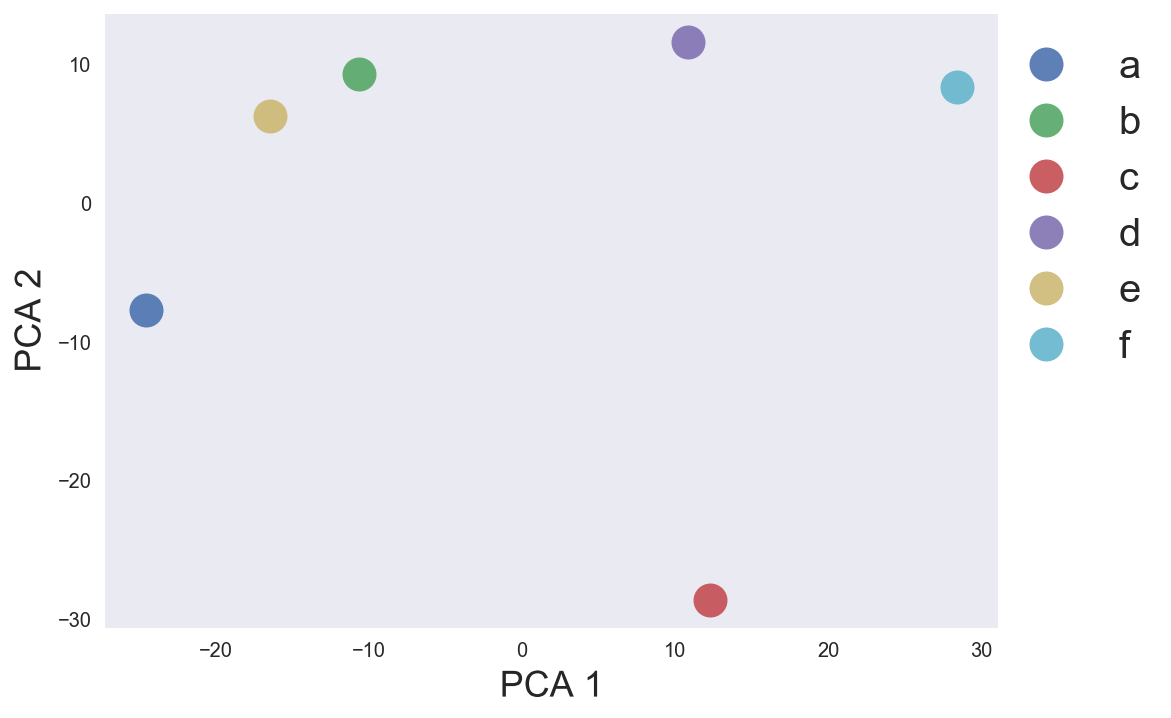

In [46]:
# PCA
pca_matrix = genpy.make_matrix(beta_filtered, genmap[(genmap.genotype != 'wt') ], 'genotype', 'qval')
sklearn_pca, n = genpy.pca(pca_matrix)
# # keep only the first principal components that explain 90% of the data
df_nD = genpy.tidy_pca(pca_matrix, n)

# # add a sample and genotype column
df_nD['genotypes'] = genmap[(genmap.genotype != 'wt') ].genotype.unique()
plot_2d_pca(df_nD, 'genotypes', 'wt', save='../output/preliminary_pca.pdf')

In [44]:
# lambda index function:
lind = lambda x: (x.qval < 0.1)

# Nomenclature

**-->**    Activating Interaction, A --> B = A activates B  
**<-->**   Activating Interaction with Direction Unknown, A --> B or B --> A equally valid  
**--|**    Inhibiting Interaction, A --| B = A inhibits B  

**--:**    Interaction with Unknown sign, A --: B = A activates or inhibits B  
**:--:**   Interaction with Unknown Sign and Direction  

**--:, --:^**    Interaction with Unknown Sign, Interaction with Unknown and Opposite Sign. I.e. A --: B --:^ C = A interacts with B, B interacts with C in the opposite way as A with B; if A --> B, then B --| C  

**--:, --::**    Interaction with Unknown Sign, Interaction with Unknown and Same Sign. I.e. A --: B --:: C = A interacts with B, B interacts with C in the same way as A with B; if A --> B, then B --> C  


# Single Mutant Analysis

There seem to be two obvious ways of analyzing this kind of data. By far the simplest method is using Spearman R analysis. 

## Correlational Transcriptome Analysis

Probably the easiest way (and undoubtedly incredibly powerful) way to get an answer about genetic interactions is to run a total correlation analysis for each pairwise combination of single mutants. The way in which I choose to do this is the following:

For two transcriptomes $X$ and $Y$:
* Find $X_{\mathrm{sig}} \cap Y_{\mathrm{sig}}$, the overlap in statistically significant genes between X and Y
* Calculate the spearman r correlation coefficient. We use spearman because it is NOT sensitive to outliers. Pearson's R is incredibly sensitive to outliers, and using it could lead to very strong answers based on a very small number of genes. Not so with Spearman's r, which only uses rank information.

After calculating the correlation coefficient, conclude that two genes are activating if:
* $\rho \ge 0.9$ 
* $p \le \alpha$, where $\alpha$ is some significance threshold

Now this is all well and good, but you may be concerned. Why do we use the overlapped gene sets, not the total genes? Part of the answer is that the total gene set is hiding a lot more interactions than the overlap. These interactions are biologically interesting, but they are not useful for answering the question, is the interaction between $X$ and $Y$ activating, deactivating or does not exist? 

Clearly, if the overlap does not exist, then $X$ and $Y$ do not interact. The size of the overlap should be tested explicitly, but bear in mind that it is also *somewhat* built into the $p$-value. 

What is the meaning of a correlation $\rho$?

Take two genes, $A$ and $B$, and measure their correlation, $\rho_{A, B}$. If they are strongly positively correlated ($>0.75$), this correlation can be generated by the following valence interactions:

**
A --> B --> X --: {g}  
B --> A --> X --: {g}  
A --> B --| X --: {g}  
B --> A --| X --: {g}  
A --: X ::-- B, X --: {g}  
**

Let the above interactions all be represented by 
**
A -gp- B**, where g: genetic, p: positive (correlation)

If two pairs of genes ${A, B}, {A, C}$ are strongly correlated, and two genes ${B, C}$ are weakly correlated ($<0.3$), then two reasonable models are:  
**
A -gp- B, A -g- C -----> C -gp- A -gp- B 
**
I.e., transitivity can generate weak relationships between genes. 

Alternatively:
**
A -gp- B, A -gp- C, B -gp- C
**
is another possibility, though here we would expect a stronger correlation between {B, C}. How much stronger is currently a subject of active research. 


Likewise, a strong negative correlation between two genes $A, B$ should result in the following valence interactions:
**
A --| B --> X --: {g}  
B --| A --> X --: {g}  
A --| B --| X --: {g}  
B --| A --| X --: {g}  
A --: X ^:-- B, X --: {g}  
**
Let the above interactions all be represented by  
**
A -gn- B**, where g: genetic, n: negative (correlation)



## Bayesian Probability of Interaction

An alternative approach to doing Correlational Transcriptome Analysis is to perform probabilistic tests of interactions. One approach is to ask for the value of:
$$
P(X -ga- Y ~|~ R_X,~ R_Y),
$$

the probability that X and Y interact positively (X --> Y and/or Y --> X) given the differentially expressed genes in $X$ and $Y$, $R_X,~R_Y$. Here, we consider that every gene in $R_X$ is a vector-like object. It has a name and a direction of change (positive or negative).

To answer that, I first model the interaction:

$$
X -ga- Y --: {g}
$$

Knocking out $X$ should lead to the perturbation of the gene expression levels of ${g}$ (again, each individual $g$ within this set is a vector-like object with a name and a direction of change), and knocking out Y should lead to exactly the same perturbations of exactly the same gene set. 

To answer our original question, we must first identify the gene set ${g}$ in question. In order to do so, we must sacrifice one of our RNA-seq datasets to provide a reference set. In order to select a reference set, I propose the heuristic:

$$
{g} := max\{|R_X|,~|R_Y|\}
$$

I.e., we arbitrarily define the set ${g}$ as the largest set of genes that are differentially expressed between $X$ and $Y$. 

Having sacrificed this gene-set, it follows that it can no longer be evidence. Without loss of generality, suppose that $R_X$ is the larger set. Then:

$$
P(X-ga-Y ~|~ R_Y) \propto P(R_Y~|X-ga-Y)P(X-ga-Y)
$$

Before we can solve this, we must ask what $P(X-ga-Y)$ is. Clearly, *a priori* the probability of the nature of the interaction can only depend on the number of interaction mechanisms there can be. Therefore, 

$$
P(X-ga-Y) = \mathrm{constant}
$$

and can be removed from the proportionality. Now, we have only to figure out $P(R_Y|X-ga-Y)$. Clearly, if $X$ actually activates $Y$, then it must be the case that:

$$
R_X = R_Y
$$

and 

$$
P(R_Y|X-ga-Y) = 1.
$$

On the contrary, if $X$ and $Y$ do not interact, we would expect that there would be an expected average overlap in the gene expression profiles, dependent to the number of genes that were upregulated in $Y$. 

Given that $|R_X|$ genes change in condition $X$, we can divide our gene set into two urns. Differentially expressed genes ($\mathcal{D}$, built from $R_X$) and non-differentially expressed genes ($\mathcal{N}$, built from ${G} - R_X$ (here, {G} is the set of all genes names that exist in this organism and changes in all possible directions)). To build our set $R_Y$, we will select genes from both $\mathcal{D}$ and $\mathcal{N}$. A function that describes this urn scenario is the hypergeometric function. 

$$
P(\mathrm{overlap} = d) = \frac{{\mathcal{|D|}\choose d}{\mathcal{|N|}-\mathcal{|D|}\choose n-d}}{{\mathcal{|N|}\choose n}}
$$

Here, $d$ is the exact overlap (gene names AND direction) between $R_X$ and $R_Y$, $n$ is the total number of genes that are differentially expressed in $R_Y$, $\mathcal{|D|}$ is the size of the differentially expressed reference urn, and $\mathcal{|N|}$ is the size of the genes that are not in $\mathcal{|D|}$.

The reader may be interested in knowing that because of the assumptions made here and the proportionality, the probability of the following models is identical:


## Other kinds of activation

For other kinds of activation, such as inhibition, we follow an identical reasoning. In the case of inhibition, we expect that ${g}$ should respond inversely between two inhibiting genes:
$$
R_X\{g, +\} = - R_Y\{g, -\}
$$


0.96


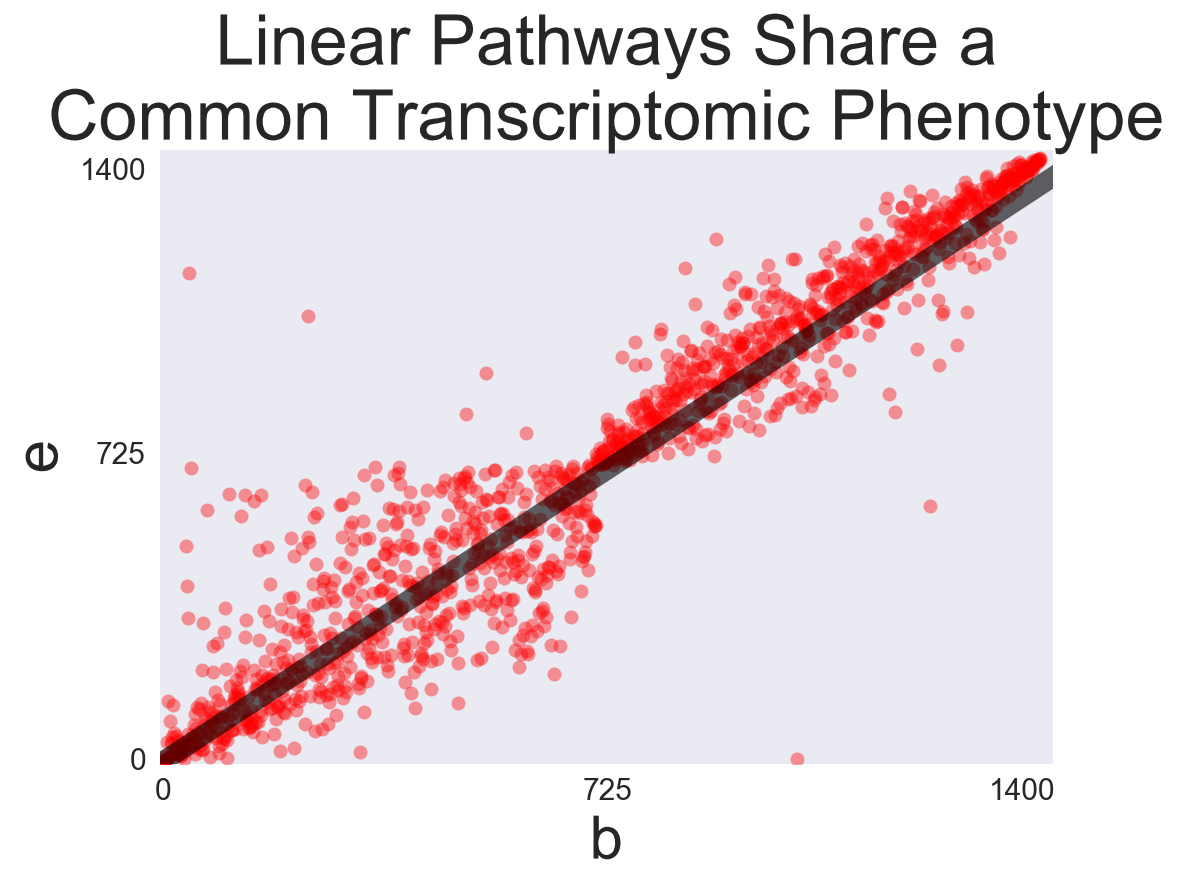

In [80]:
# As an example, let me show you what a good spearman correlation looks like:
genes = 'target_id'

letters = ['b', 'e']

x = beta_filtered[letters[0]]
y = beta_filtered[letters[1]]

ovx = x[lind(x)]
ovy = y[lind(y) & y[genes].isin(ovx[genes])].copy()
ovx = x[lind(x) & x[genes].isin(ovy[genes])].copy()

xns = x[~x.target_id.isin(ovx.target_id)].copy()
yns = y[~y.target_id.isin(ovx.target_id)].copy()

def find_rank(df):
    
    df.sort_values('b', inplace=True)
    rank = np.linspace(0, len(df)-1, len(df))
    df['r'] = rank
    df.sort_values('target_id', inplace=True)

find_rank(ovx)
find_rank(ovy)
find_rank(xns)
find_rank(yns)



# plt.plot(xns.r, yns.r, 'ko', alpha=.5, label='All Genes' )


r = stats.spearmanr(ovx.b, ovy.b)[0]
X = np.linspace(-5, 1600)
Y = r*X

print('{0:.2g}'.format(r))
plt.plot(ovx.r, ovy.r, 'ro', alpha=0.4, label='Overlapped Diff. Exp. Genes')

plt.plot(X, Y, 'k-', alpha=0.6, lw=10, label= 'Best Fit')

plt.xlim(-5, 1450)
plt.ylim(-5, 1450)

plt.title('Linear Pathways Share a\nCommon Transcriptomic Phenotype', fontsize=ft).\
            set_path_effects([path_effects.Normal()])
plt.xlabel(letters[0], fontsize=30).set_path_effects([path_effects.Normal()])
plt.ylabel(letters[1], fontsize=30).set_path_effects([path_effects.Normal()])

plt.xticks([0, 725, 1400], fontsize=15)
plt.yticks([0, 725, 1400], fontsize=15)

plt.savefig('../output/spearmanr_b_and_c.pdf')

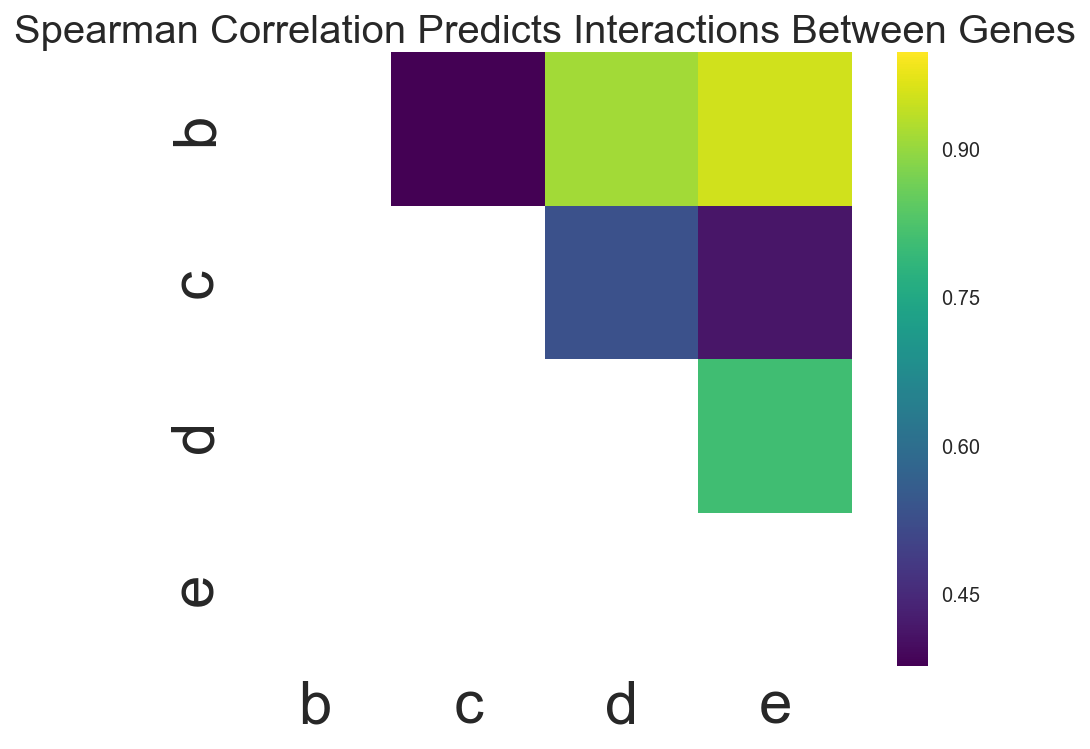

In [102]:
# Perform Correlation Analysis

def tri_plot(matrix, xlabels, ylabels=[]):
    if len(ylabels) == 0:
        ylabels = xlabels
        
    mask = np.zeros_like(matrix)
    mask[np.tril_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(matrix, xticklabels=xlabels, yticklabels=ylabels, cmap='viridis',
                         mask=mask, square=True)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

res_dict = genpy.single_mutant_analysis(single_mutants, beta_filtered)

rho_matrix = res_dict['rho']
tri_plot(rho_matrix, single_mutants)
plt.title('Spearman Correlation Predicts Interactions Between Genes', fontsize=20)
plt.savefig('../output/spearmr_matrix_single_mutants.pdf', bbox_inches='tight')

In [103]:
# Print the spearman correlation matrix viewed above to get the numbers exactly:
rho_matrix

array([[ 1.        ,  0.37917859,  0.91505205,  0.9554592 ],
       [ 0.37917859,  1.        ,  0.53405474,  0.41450883],
       [ 0.91505205,  0.53405474,  1.        ,  0.81031963],
       [ 0.9554592 ,  0.41450883,  0.81031963,  1.        ]])

From the above, we can draw the following arrows:


Interaction | $\rho$ |
----------- | ------- |
b -gp- d| 0.92
b -gp- e| 0.96
d -gp- e| 0.81
d -gp- c| 0.53
b -gp- c| 0.38
e -gp- c| 0.41

We can see {B, D, E} make a tightly correlated cluster - i.e., they share an output.

C is an outgroup to {B, D, E} and is weakly correlated to them all, meaning there is a possible positive correlation between C -gp- {B, D, E}. However, the weakness of the sign makes me doubt whether it is actually a positive interaction.... For the moment, settle for C -g- {B, D, E}

Moreover, we notice that B -g- D and B -g- E are very close to one, and E -g- D is weaker, so we should consider the possibility of transitivity: 

E -gp- B -gp- D

[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]


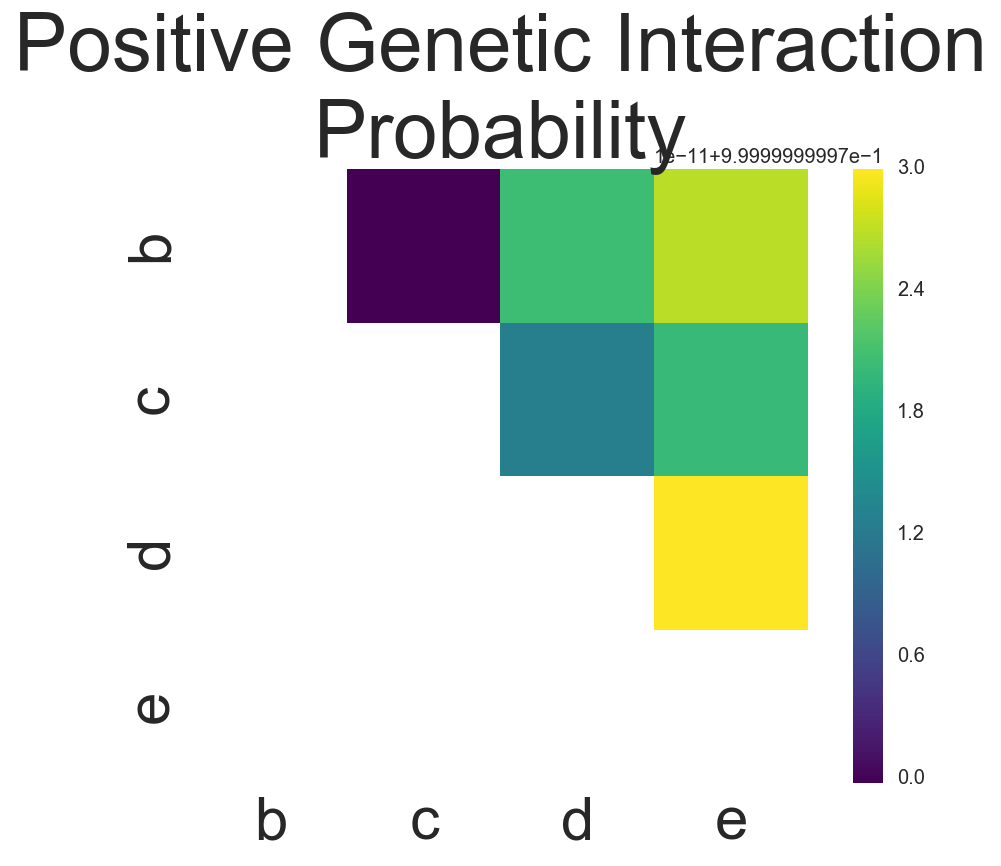

In [83]:
res_dict = genpy.single_mutant_analysis(single_mutants, beta_filtered, analysis='interaction')

tri_plot(res_dict['prob_pos'], single_mutants)
print(res_dict['prob_pos'])
plt.title('Positive Genetic Interaction\nProbability', fontsize=40)
plt.savefig('../output/probability_of_interaction_single_mutants.pdf', bbox_inches='tight')

[[  1.96765865e-123   3.55671271e-002   3.82763702e-043   3.81496274e-157]
 [  3.55671271e-002   2.79700830e-033   1.07186953e-001   6.84450863e-007]
 [  3.82763702e-043   1.07186953e-001   1.30200599e-033   4.40225705e-049]
 [  3.81496274e-157   6.84450863e-007   4.40225705e-049   1.45968472e-240]]


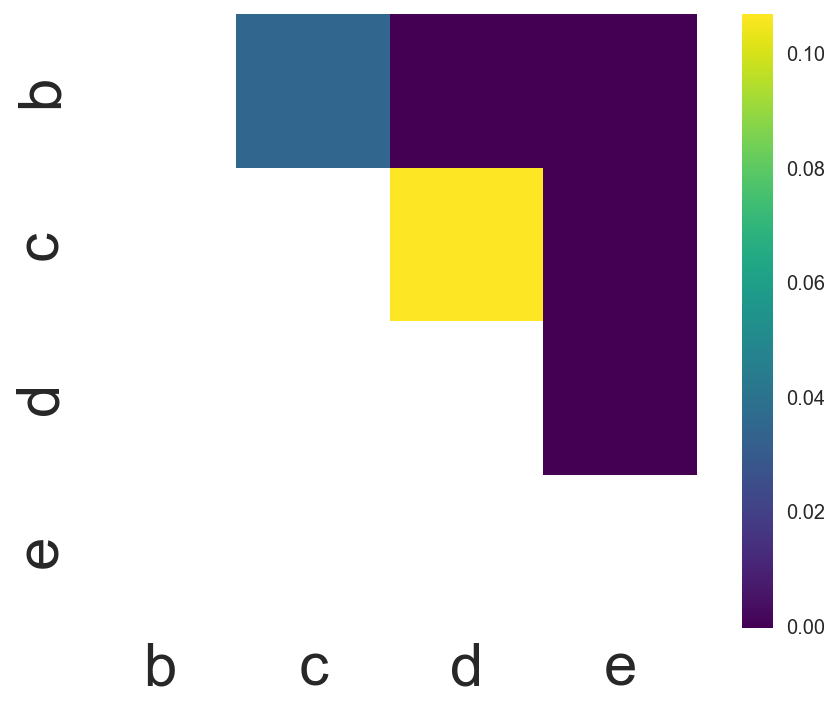

In [85]:
tri_plot(res_dict['prob_minus'], single_mutants)
print(res_dict['prob_minus'])

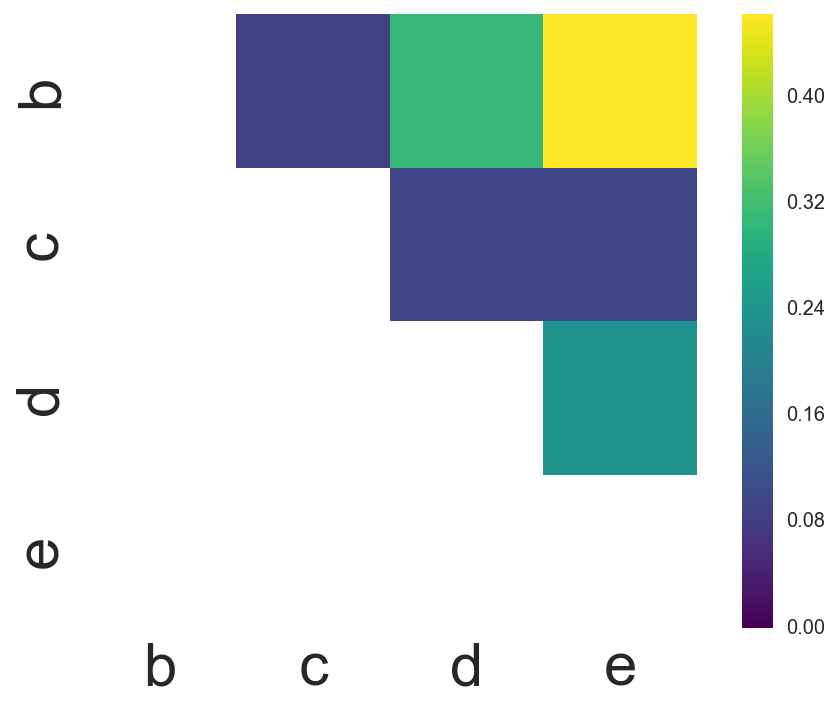

In [87]:
tri_plot(res_dict['overlap_pos'],single_mutants)

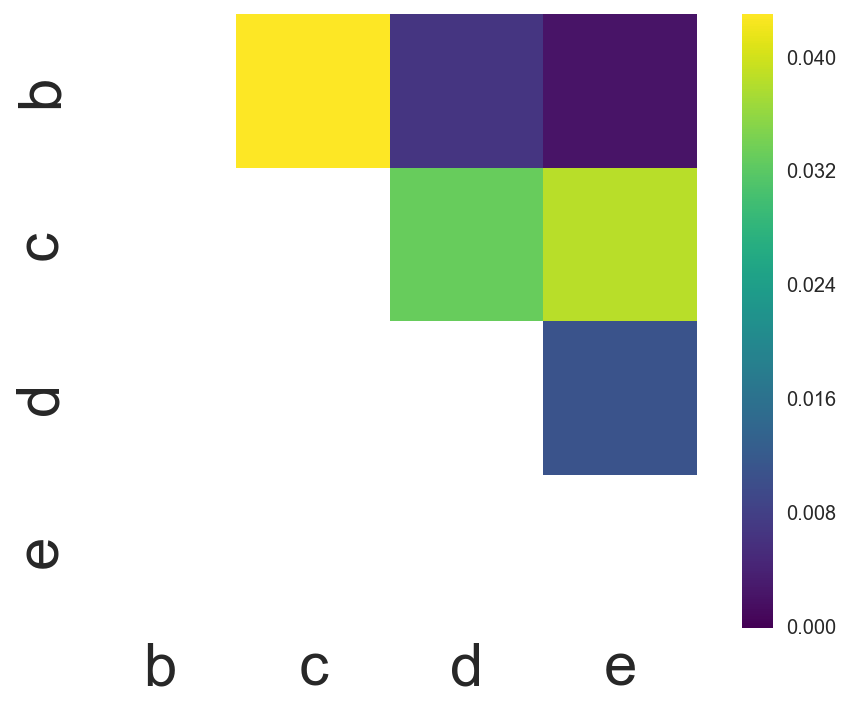

In [68]:
tri_plot(res_dict['overlap_minus'],single_mutants)

# Conclusions from Probabilistic Analysis:

b -gp- d  
b -gp- e  
b !- e     (different results from TrCA)  

b -gm- e  
b -gm- d  

There seems to be enough evidence that for some genes there is negative feedback between {b, d} and {b, e}

# Conclusions from Single Mutant Analysis:

Certainly, it seems likely that:

b -gp- d  
b -gp- e  

Taken together with the low probability of interaction between {e, d} as measured by hypergeometric and TrCA, I would guess that:

d -gp- b -gp- e  

No conclusion can be drawn at this point about c. There's also some evidence of inhibitory loops affecting

b -gm- d  
b -gm- e  

I shouldn't forget that previously we concluded that there were interactions with c of currently ambiguous sign:

c -g- d
c -g- e
c -g- b

If we assume that {d, b, e} are exhibiting transitiveness, then it's likely that:

c -g- d
c -g- {b, e}  

Taken together, at this point I would guess:  
b -gp- d, b -gn- d  
b -gp- e, b -gn- e  
d -g- c  
{b,e} -g- c

# Double Mutant Analysis

With double mutants, the analysis gets slightly more complicated. Now we're getting into full pathways!

A first approach is to inspect the double mutants by Spearman correlation analysis to the single mutants that make them up. A quick visualization will show us any epistasis and the extent of it:

a b 0.97
a d 0.89
f b 0.65
f c 0.71


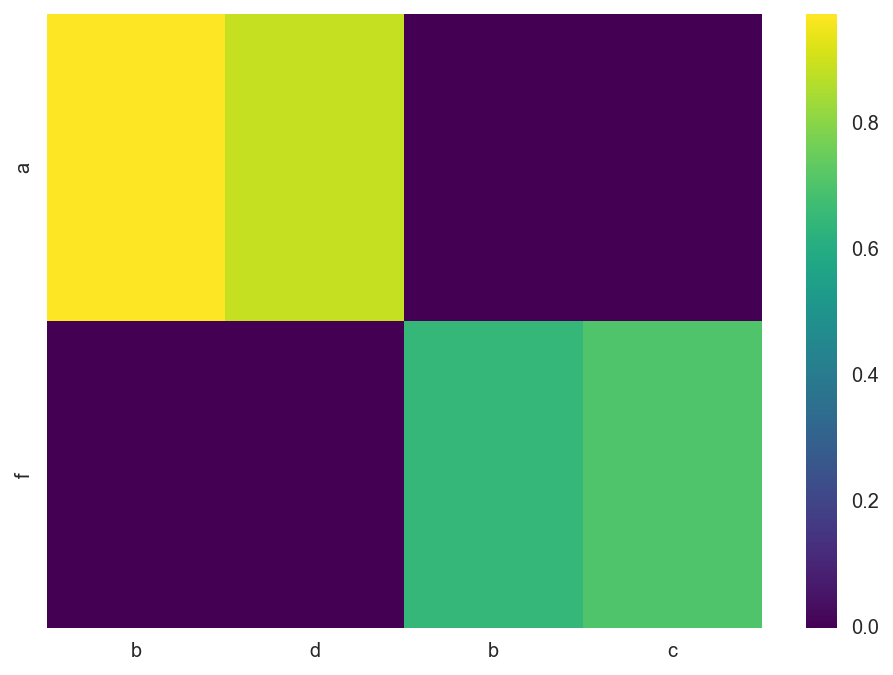

In [88]:
rho_matrix_doubles = genpy.double_mutant_corr_analysis(double_mutants, beta_filtered)


# tri_plot(rho_matrix_doubles, ['b', 'd','b','c'], ['a', 'f'])
xticklabels = []
yticklabels = []
for key in double_mutants:
    xticklabels += double_mutants[key]
    yticklabels += key
sns.heatmap(rho_matrix_doubles, xticklabels=xticklabels, yticklabels=yticklabels, cmap='viridis')


Clearly, mutant a shows epistasis between {b, c}, whereas f seems to have equal(ish) contributions from {d, b}.

We can satisfy ourselves that there is only one kind of pathway s.t.  
$$
b^- = b^-d^-
$$

And that must be:  
c -| b -: g

Knocking out c causes g to go up. Knocking out b should cause no change in g if c is present. If c is not present, knocking out b should cause g to go down. The double mutant should match either case. 

Therefore:
c -| b


In [89]:
res_dict_double = genpy.double_mutant_analysis(double_mutants, beta_filtered)

In [90]:
for key in res_dict_double:
    print(key, res_dict_double[key])

('f', 'epistasis_odds') 4.9522608238e-12
('a', 'epistasis_magnitude') 1.0
('f', 'epistasis_magnitude') 0.999999999971
('a', 'epistasis_odds') -7.84639020427e-12


In [91]:
double_mat = np.zeros(shape=(2, 4))
l = 0
cols = []
for key in double_mutants:
    m = 0
    cols += [key]
    for j in single_mutants:
        x = beta_filtered[key]
        y = beta_filtered[j]
        
        ovx = x[lind(x)]
        ovy = y[lind(y) & y.target_id.isin(ovx.target_id)]
        ovx = x[lind(x) & x.target_id.isin(ovy.target_id)]
        
        rho = stats.spearmanr(ovx.b, ovy.b)
        print(key, j, '{0:.2g}'.format(rho[0]))
        double_mat[l, m] = rho[0]
        m += 1
    l += 1

a b 0.97
a c 0.041
a d 0.89
a e 0.92
f b 0.65
f c 0.71
f d 0.47
f e 0.73


$$
f^- = b^-d^-
$$

$$
a^- = b^-c^-
$$

$$
b^- = d^- = e^- = b^-c^-
$$
















$$
b^-d^- \sim b^-
$$

$$
b^-d^- \sim c^-
$$

$$
b^-d^- \sim e^-
$$

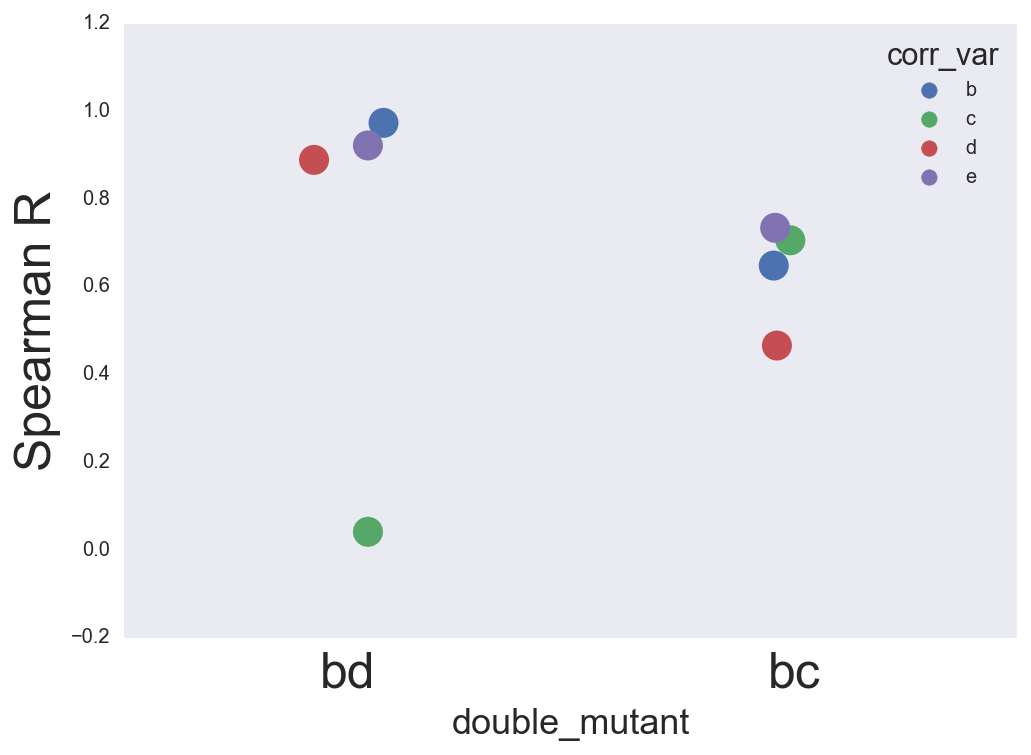

In [92]:
double_corr = pd.DataFrame(double_mat.transpose(), columns=cols)
double_corr = pd.melt(double_corr, var_name='double_mutant', value_name='spearmanr')
double_corr['corr_var'] = single_mutants*2

sns.stripplot(x='double_mutant', y='spearmanr', hue='corr_var', data=double_corr, size=15, jitter=True)
ax = plt.gca()

xlabels = []
for c in double_corr.double_mutant.unique():
    xlabels += [double_mutants[c]]

x = np.linspace(0, len(ax.get_xticklabels())-1, len(ax.get_xticklabels()))
plt.xticks(x, xlabels, fontsize=25)
plt.ylabel('Spearman R', fontsize=25)
# plt.xticks(xlabels, fontsize=25)

# plt.title('Double Mutants Have Additive and Epistatic Effects ')
plt.savefig('../output/epistasis_spearmanr.pdf')

In [ ]:
double_corr.head()

In [ ]:
# perform TEA on these things... 

l = 0
m = 0
tissue_df= tea.fetch_dictionary() 
tissues = {}
for i in single_mutants:
    m = l
    for j in single_mutants[l:]:
        if i == j:
            continue
        if len(res_dict['ids'][('plus', i, j)]) > 10:
            ids = res_dict['ids'][('plus', i, j)]
            wbids = beta_filtered['a'][beta_filtered['a'].target_id.isin(ids)].ens_gene
            df_res, unused= tea.enrichment_analysis(wbids, tissue_df, show= False, save= False)
            if len(df_res) > 0:
                tissues[('plus', i, j)] = df_res
            print(i, j)
        m += 1
    l += 1

In [ ]:
tissues[('plus', 'b', 'e')]

In [ ]:
for keys in tissues:
    print(keys)

In [ ]:
l = 0
m = 0
tissue_df= tea.fetch_dictionary() 
tissues = {}
for sign in ['plus', 'minus']:
    l=0
    if sign == 'plus':
        s = 'pos'
    else:
        s = 'minus'
    for i in single_mutants:
        m = l
        for j in single_mutants[l:]:
            if i == j:
                continue
        
            ids = res_dict['ids'][(sign, i, j)]
            if len(ids) < 100:
                continue
            wbids = beta_filtered['a'][beta_filtered['a'].target_id.isin(ids)].ens_gene
            df_res, unused= tea.enrichment_analysis(wbids, tissue_df, show= False, save= False)
            if len(df_res) > 0:
                tissues[(sign, i, j)] = df_res
                print(i, j, len(res_dict['ids'][(sign, i, j)]))
            m += 1
    l += 1

In [ ]:
ids = res_dict['ids'][('plus', 'b', 'd')]
bids = beta_filtered['a'][beta_filtered['a'].target_id.isin(ids)].ens_gene

In [ ]:
tiss = {}
for i in single_mutants:
    df = beta_filtered[i]
    wbids = df[df.qval < 0.1].ens_gene
    df_res, unused = tea.enrichment_analysis(wbids, tissue_df, show=False, save=False)
    if len(df_res) > 0:
        tiss[i] = df_res
        print(i)

In [ ]:
# find all the genes in the hypoxia response:
ovb = beta_filtered['b'].copy()
ovd = beta_filtered['d']
ove = beta_filtered['e']

ovb.sort_values('target_id', inplace=True)
ovd.sort_values('target_id', inplace=True)
ove.sort_values('target_id', inplace=True)

ovb['d_qval'] = ovd.qval
ovb['e_qval'] = ove.qval

ovb['d_b'] = ovy.b
ovb['e_b'] = ovz.b

ind1 = (ovb.qval < 0.1)
ind2 = (ovb.d_qval < 0.1)
ind3 = (ovb.e_qval < 0.1)

ind4 = (ovb.b*ovb.d_b*ovb.e_b > 0)

hypoxia_genes = ovb[ind1 & ind2 & ind3 & ind4]

# # first find the overlap in the gene responses:
# ind1 = (genpy.find(ovx, ovy[ovy.qval < 0.1].target_id))
# ind2 = (genpy.find(ovx, ovz[ovz.qval < 0.1].target_id))
# ind3 = (ovx.qval < 0.1)

# overlapped_genes = ovx[ind1 & ind2 & ind3].copy()

# # figure out if they agree in the way they respond:
# indy = (genpy.find(ovy, overlapped_genes.target_id))
# indz = (genpy.find(ovz, overlapped_genes.target_id))

# # print(len(overlapped_genes))
# # print(len(ovy[indy]))

# overlapped_genes.sort_values('target_id')

# def check_y(x):
#     sel1 = (ovy.target_id == x)
#     sel2 = (ovx.target_id == x)
#     return ovy[sel1].b.values[0]*ovx[sel2].b.values[0]

# def check_z(x):
#     sel1 = (ovz.target_id == x)
#     sel2 = (ovx.target_id == x)
#     return ovz[sel1].b.values[0]*ovx[sel2].b.values[0]

# def check_yz(x):
#     sel1 = (ovy.target_id == x)
#     sel2 = (ovz.target_id == x)
#     return ovy[sel1].b.values[0]*ovz[sel2].b.values[0]
    
# overlapped_genes['corr_xy'] = overlapped_genes.target_id.apply(check_y)
# overlapped_genes['corr_xz'] = overlapped_genes.target_id.apply(check_y)
# overlapped_genes['corr_yz'] = overlapped_genes.target_id.apply(check_y)
# # print(len(hypoxia_genes))

# ind1 = (overlapped_genes.corr_xy > 0)
# ind2 = (overlapped_genes.corr_xz > 0)
# ind2 = (overlapped_genes.corr_yz > 0)

# hypoxia_genes = overlapped_genes[ind1 & ind2 & ind3]

In [ ]:
# for gene in hypoxia_genes.ens_gene:
#     print(gene)
tissue_df= tea.fetch_dictionary()    
df_res, unused = tea.enrichment_analysis(hypoxia_genes.ens_gene, tissue_df, save=False)

In [ ]:
plt.plot(hypoxia_genes.b, -np.log(hypoxia_genes.qval), 'o')

In [ ]:
i=0
for gene in hypoxia_genes.ext_gene.unique():
    print(gene)
    i+=1
print(i)

In [ ]:
print(len(hypoxia_genes))

# Quality Control

Load up the hypoxia gold standard Carmie gave me. These genes are expected to go up in everything except in Hif-1. 

By this point, I have solved the network, I guessed which gene was Hif-1 and I have been told the identities of the genes. 

C = Hif-1  
B = egl-9  
D = vhl-1  
E = rhy-1  

nhr-57 is an important gene for hypoxia. WBID is WBGene00003647

In [110]:
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv', sep=',')

# nhr-57 

In [111]:
# Figure out how many hits we get and if the pvalue is significant!
for sm in single_mutants:
    df = beta[sm]
    ind = (genpy.find(df, hypoxia_gold.WBIDS, col='ens_gene'))
    found = df[ind & (df.qval < 0.1)]
    sig = df[df.qval < 0.1]
    pval = stats.hypergeom.sf(len(found), len(df), len(hypoxia_gold), len(sig))
    print('genotype: ', sm)
    print('found: ', len(found), '      Mean b: {0:.2g}'.format(found.b.mean()))
    print('pval: {0:.2g}'.format(pval))
    
    
    print('Maximum change was:')
    print(found[found.b == found.b.max()].ext_gene.values[0])
    print(np.exp(found[found.b == found.b.max()].b.values)[0], ' fold change')
    if 'WBGene00003647' in found.ens_gene.values:
        nhr57 = found[found.ens_gene == 'WBGene00003647'].b.values[0]
        print('nhr-57 is in', sm, 'and its fold change was {0:.2g}'.format(nhr57))
    
    print('----------')
    


genotype:  b
found:  15       Mean b: 2.8
pval: 5.3e-15
Maximum change was:
oac-54
65.3416617632  fold change
nhr-57 is in b and its fold change was 4.1
----------
genotype:  c
found:  1       Mean b: 0.46
pval: 0.15
Maximum change was:
rhy-1
1.58146039596  fold change
----------
genotype:  d
found:  10       Mean b: 2.1
pval: 1.5e-11
Maximum change was:
fmo-2
48.180485028  fold change
nhr-57 is in d and its fold change was 2
----------
genotype:  e
found:  14       Mean b: 2.3
pval: 8.5e-12
Maximum change was:
nhr-57
46.2035111021  fold change
nhr-57 is in e and its fold change was 3.8
----------


In [55]:
# find all the genes in the hypoxia response:
ovb = beta_filtered['b'].copy()
ovd = beta_filtered['d'].copy()
ove = beta_filtered['e'].copy()

# ovb.sort_values('target_id', inplace=True)
# ovd.sort_values('target_id', inplace=True)
# ove.sort_values('target_id', inplace=True)

ovb['d_qval'] = ovd.qval
ovb['e_qval'] = ove.qval

def retrieve_d(x):
    ind = (ovd.target_id == x)
    return ovd[ind].b.values[0]

def retrieve_e(x):
    ind = (ovd.target_id == x)
    return ovd[ind].b.values[0]

ovb['d_b'] = ovd.b
ovb['e_b'] = ove.b
ind1 = (ovb.qval < 0.1)
ind2 = (ovb.d_qval < 0.1)
ind3 = (ovb.e_qval < 0.1)

ind4 = (ovb.b*ovb.d_b*ovb.e_b > 0)

hypoxia_genes = ovb[ind1 & ind2 & ind3 & ind4]


In [56]:
ovd.head()

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene
0,18040,AC3.10,0.989210,0.999692,0.003315,0.245128,3.654303,0.066103,0.025083,0.057541,0.065049,0.065049,WBGene00004964,spe-10
1,8676,AC3.2,0.436860,0.929678,0.077026,0.099068,5.449583,0.006725,0.004505,0.001676,0.010216,0.010216,WBGene00007070,ugt-49
2,16240,AC3.5a.1,0.890479,0.999481,-0.066108,0.480091,6.133368,0.121258,0.338877,-0.188944,0.006854,0.006854,WBGene00007071,AC3.5
3,13498,AC3.5a.2,0.718949,0.982317,-0.405718,1.127424,4.564337,0.477856,1.885470,-1.349878,0.021158,0.021158,WBGene00007071,AC3.5
4,13499,AC3.5b,0.718949,0.982317,-0.405718,1.127424,4.564337,0.477856,1.885470,-1.349878,0.021158,0.021158,WBGene00007071,AC3.5


In [57]:
ovb.head()

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,d_qval,e_qval,d_b,e_b
0,9365,AC3.10,0.415437,0.825933,-0.256932,0.315500,3.485494,0.139253,0.033625,0.115686,0.096578,0.115686,WBGene00004964,spe-10,0.999692,0.954497,0.003315,0.071116
1,3589,AC3.2,0.060152,0.311971,-0.213712,0.113696,5.265059,0.017700,0.005884,-0.000886,0.013506,0.013506,WBGene00007070,ugt-49,0.929678,0.711754,0.077026,0.096442
2,13683,AC3.5a.1,0.690343,0.938118,-0.154356,0.387451,6.050045,0.115412,0.217270,-0.081940,0.007907,0.007907,WBGene00007071,AC3.5,0.999481,0.895761,-0.066108,0.166487
3,13741,AC3.5a.2,0.693613,0.940113,-0.462836,1.174840,4.496705,0.298447,2.042717,-1.749990,0.027658,0.027658,WBGene00007071,AC3.5,0.982317,0.873492,-0.405718,-0.655825
4,13742,AC3.5b,0.693613,0.940113,-0.462836,1.174840,4.496705,0.298447,2.042717,-1.749990,0.027658,0.027658,WBGene00007071,AC3.5,0.982317,0.873492,-0.405718,-0.655825


In [59]:
len(hypoxia_genes)

280

In [82]:
for wbid in hypoxia_genes.ens_gene.unique():
    if str(wbid) == 'nan':
        continue
#     print(wbid)

In [79]:
for key in res_dict['ids'].keys():
    if key[0] == 'plus':
        if key[1] == 'c' or key[2] == 'c':
            continue
        if key[1] == key[2]:
            continue
        print(key[1], key[2], len(res_dict['ids'][key]))

d b 692
b d 692
e b 1424
e d 690
b e 1424
d e 690
